In [1]:
# specify train, validation and test path 
train_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/train'
val_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/val'
test_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/data/test'

# specify project directory in google drive
project_dir = '/content/drive/MyDrive/MyProjects/garbage_img_classification/'

# saved model name
model_name = 'best_vggblocks.h5'

# Garbage Image Classification

## Objective 
To classify type of garbage in an image.  
This dataset contains 6 types of garbage;  
- cardboard (393 images)  
- glass (491 images)  
- metal (400 images)  
- paper (584 images)  
- plastic (472 images)  
- trash (127 images)

## Dataset
source : https://www.kaggle.com/asdasdasasdas/garbage-classification

## Approach
Baseline model : 
- CNN model with 1 VGG block  
- CNN model with 2 VGG blocks
- CNN model with 3 VGG blocks

Improved models :
- dropout layers
- data augmentation
- batch normalization

## Create Image Data Generator (without data augmentation)

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## F-beta score function

In [3]:
from tensorflow.keras import backend

# optional sklearn.metrics.fbeta_score (cannot be used as training metric)
#from sklearn.metrics import fbeta_score

In [4]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

## Evaluation function

In [5]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

### Baseline model 1 : 1 vgg-block model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

Epoch 1/100
89/89 [==============================] - 813s 9s/step - loss: 15.2499 - fbeta: 0.1160 - val_loss: 1.3812 - val_fbeta: 0.1941
Epoch 2/100
89/89 [==============================] - 8s 94ms/step - loss: 1.1053 - fbeta: 0.3354 - val_loss: 1.3185 - val_fbeta: 0.3074
Epoch 3/100
89/89 [==============================] - 8s 94ms/step - loss: 0.5834 - fbeta: 0.6788 - val_loss: 1.4444 - val_fbeta: 0.4279
Epoch 4/100
89/89 [==============================] - 8s 94ms/step - loss: 0.2492 - fbeta: 0.8882 - val_loss: 1.8061 - val_fbeta: 0.4412
Epoch 5/100
89/89 [==============================] - 8s 93ms/step - loss: 0.1185 - fbeta: 0.9520 - val_loss: 2.2010 - val_fbeta: 0.4618
Epoch 6/100
89/89 [==============================] - 8s 94ms/step - loss: 0.0854 - fbeta: 0.9685 - val_loss: 2.4740 - val_fbeta: 0.5147
Epoch 7/100
89/89 [==============================] - 8s 95ms/step - loss: 0.0673 - fbeta: 0.9724 - val_loss: 2.3585 - val_fbeta: 0.4603
Epoch 8/100
89/89 [============================

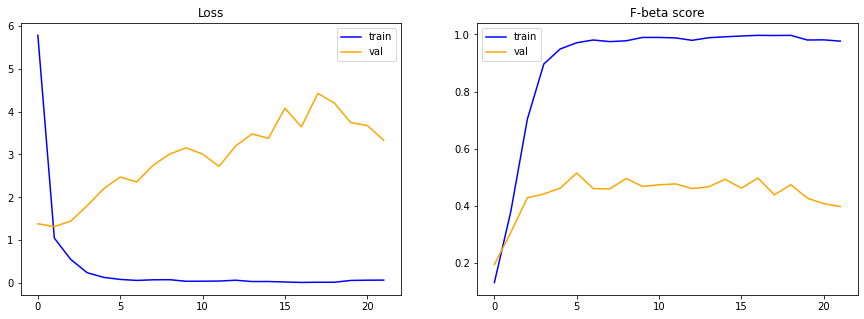

Model F-beta score :  0.4477957785129547


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
baseline1_perf = evaluate_model(history)

### Baseline model 2 : 2 vgg-block model

Epoch 1/100
89/89 [==============================] - 9s 97ms/step - loss: 3.9022 - fbeta: 0.0784 - val_loss: 1.5051 - val_fbeta: 0.1735
Epoch 2/100
89/89 [==============================] - 9s 96ms/step - loss: 1.2292 - fbeta: 0.2637 - val_loss: 1.2715 - val_fbeta: 0.2897
Epoch 3/100
89/89 [==============================] - 9s 96ms/step - loss: 0.9325 - fbeta: 0.4765 - val_loss: 1.3646 - val_fbeta: 0.3500
Epoch 4/100
89/89 [==============================] - 8s 95ms/step - loss: 0.5857 - fbeta: 0.6967 - val_loss: 1.4741 - val_fbeta: 0.4118
Epoch 5/100
89/89 [==============================] - 9s 96ms/step - loss: 0.3187 - fbeta: 0.8580 - val_loss: 1.9180 - val_fbeta: 0.4382
Epoch 6/100
89/89 [==============================] - 8s 94ms/step - loss: 0.2289 - fbeta: 0.9023 - val_loss: 2.4975 - val_fbeta: 0.5147
Epoch 7/100
89/89 [==============================] - 8s 95ms/step - loss: 0.1306 - fbeta: 0.9450 - val_loss: 2.3109 - val_fbeta: 0.5162
Epoch 8/100
89/89 [=============================

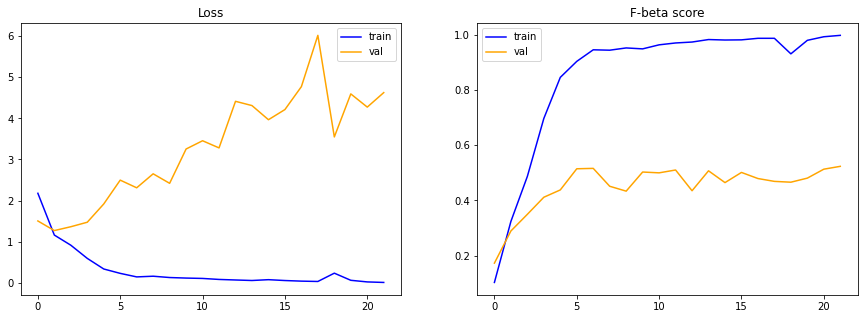

Model F-beta score :  0.5220417380332947


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
baseline2_perf = evaluate_model(history)

Note : there is overfitting problem

### Baseline model 3 : 3 vgg-block model

Epoch 1/100
89/89 [==============================] - 9s 97ms/step - loss: 3.4019 - fbeta: 0.0534 - val_loss: 1.4092 - val_fbeta: 0.1853
Epoch 2/100
89/89 [==============================] - 9s 97ms/step - loss: 1.5022 - fbeta: 0.1343 - val_loss: 1.4553 - val_fbeta: 0.2015
Epoch 3/100
89/89 [==============================] - 9s 96ms/step - loss: 1.2730 - fbeta: 0.2391 - val_loss: 1.2383 - val_fbeta: 0.2882
Epoch 4/100
89/89 [==============================] - 9s 97ms/step - loss: 1.1241 - fbeta: 0.3627 - val_loss: 1.2489 - val_fbeta: 0.3000
Epoch 5/100
89/89 [==============================] - 9s 96ms/step - loss: 0.9265 - fbeta: 0.5050 - val_loss: 1.1469 - val_fbeta: 0.3765
Epoch 6/100
89/89 [==============================] - 8s 95ms/step - loss: 0.7398 - fbeta: 0.6068 - val_loss: 1.2309 - val_fbeta: 0.5029
Epoch 7/100
89/89 [==============================] - 8s 95ms/step - loss: 0.6237 - fbeta: 0.6905 - val_loss: 1.3050 - val_fbeta: 0.5176
Epoch 8/100
89/89 [=============================

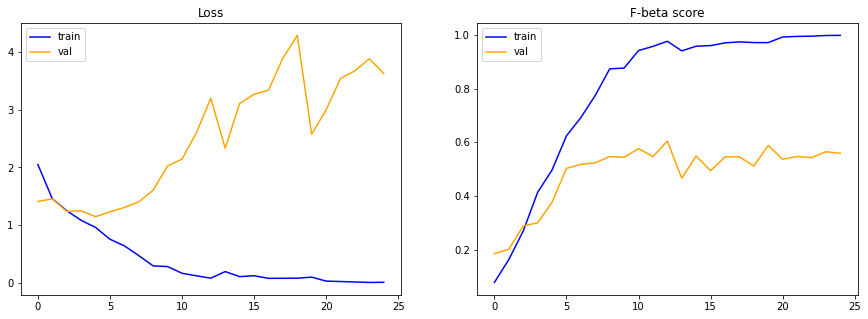

Model F-beta score :  0.6171693205833435


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
baseline3_perf = evaluate_model(history)

In [ ]:
# Note :  Baseline models performance
print('Baseline 1 : ', baseline1_perf)
print('Baseline 2 : ', baseline2_perf)
print('Baseline 3 : ', baseline3_perf)

Baseline 1 :  0.4477957785129547
Baseline 2 :  0.5220417380332947
Baseline 3 :  0.6171693205833435


## Improved Models

### model 1 : Baseline + dropout layers

Epoch 1/100
89/89 [==============================] - 10s 101ms/step - loss: 3.6909 - fbeta: 0.0339 - val_loss: 1.5535 - val_fbeta: 0.0971
Epoch 2/100
89/89 [==============================] - 9s 99ms/step - loss: 1.5734 - fbeta: 0.0670 - val_loss: 1.4717 - val_fbeta: 0.1382
Epoch 3/100
89/89 [==============================] - 9s 95ms/step - loss: 1.4395 - fbeta: 0.1719 - val_loss: 1.2921 - val_fbeta: 0.1824
Epoch 4/100
89/89 [==============================] - 9s 96ms/step - loss: 1.3000 - fbeta: 0.2000 - val_loss: 1.4303 - val_fbeta: 0.0882
Epoch 5/100
89/89 [==============================] - 8s 94ms/step - loss: 1.2445 - fbeta: 0.2609 - val_loss: 1.2543 - val_fbeta: 0.2809
Epoch 6/100
89/89 [==============================] - 9s 96ms/step - loss: 1.1606 - fbeta: 0.3188 - val_loss: 1.2316 - val_fbeta: 0.2588
Epoch 7/100
89/89 [==============================] - 8s 95ms/step - loss: 1.0856 - fbeta: 0.3786 - val_loss: 1.1955 - val_fbeta: 0.2985
Epoch 8/100
89/89 [===========================

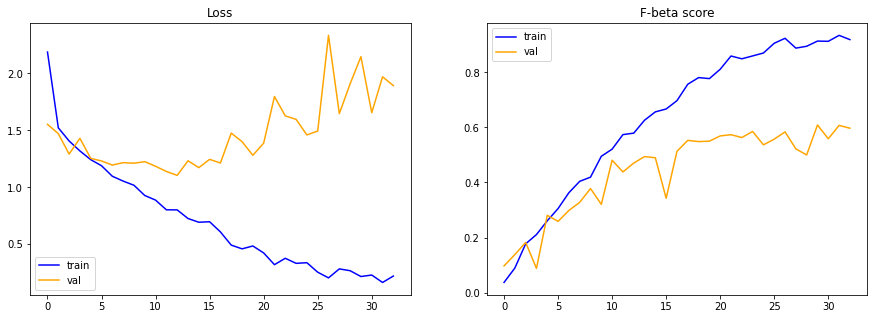

Model F-beta score :  0.6171693205833435


In [ ]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model1_perf = evaluate_model(history)

Note : there is still overfitting

### model 2 : Baseline + data augmentation

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 15s 164ms/step - loss: 3.0461 - fbeta: 0.0150 - val_loss: 1.7394 - val_fbeta: 0.0000e+00
Epoch 2/100
89/89 [==============================] - 14s 160ms/step - loss: 1.6072 - fbeta: 0.0323 - val_loss: 1.6540 - val_fbeta: 0.0088
Epoch 3/100
89/89 [==============================] - 14s 159ms/step - loss: 1.5547 - fbeta: 0.0750 - val_loss: 1.4415 - val_fbeta: 0.1662
Epoch 4/100
89/89 [==============================] - 14s 161ms/step - loss: 1.4564 - fbeta: 0.1182 - val_loss: 1.3021 - val_fbeta: 0.2412
Epoch 5/100
89/89 [==============================] - 14s 162ms/step - loss: 1.3548 - fbeta: 0.2078 - val_loss: 1.3498 - val_fbeta: 0.2279
Epoch 6/100
89/89 [==============================] - 14s 161ms/step - loss: 1.2954 - fbeta: 0.2534 - val_loss: 1.3946 - val_fbeta: 0.1809
Epoch 7/100
89/89 [=========================

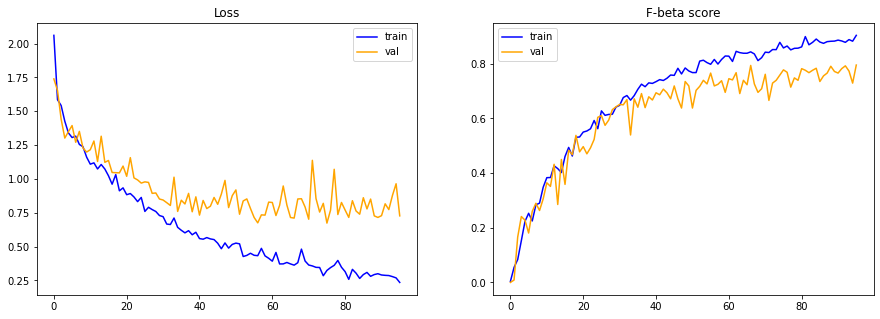

Model F-beta score :  0.7888630628585815


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model2_perf = evaluate_model(history)

Note : overfitting is reduced clearly

### model 3 : Baseline + data augmentation + dropout layers

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 15s 162ms/step - loss: 4.5110 - fbeta: 0.0303 - val_loss: 1.7756 - val_fbeta: 0.0000e+00
Epoch 2/200
89/89 [==============================] - 14s 162ms/step - loss: 1.7263 - fbeta: 5.4831e-04 - val_loss: 1.6148 - val_fbeta: 0.0176
Epoch 3/200
89/89 [==============================] - 14s 160ms/step - loss: 1.5948 - fbeta: 0.0705 - val_loss: 1.7148 - val_fbeta: 0.0176
Epoch 4/200
89/89 [==============================] - 14s 159ms/step - loss: 1.5965 - fbeta: 0.0809 - val_loss: 1.5824 - val_fbeta: 0.0588
Epoch 5/200
89/89 [==============================] - 14s 161ms/step - loss: 1.5502 - fbeta: 0.0822 - val_loss: 1.5514 - val_fbeta: 0.0559
Epoch 6/200
89/89 [==============================] - 14s 160ms/step - loss: 1.5303 - fbeta: 0.0810 - val_loss: 1.5383 - val_fbeta: 0.0706
Epoch 7/200
89/89 [=====================

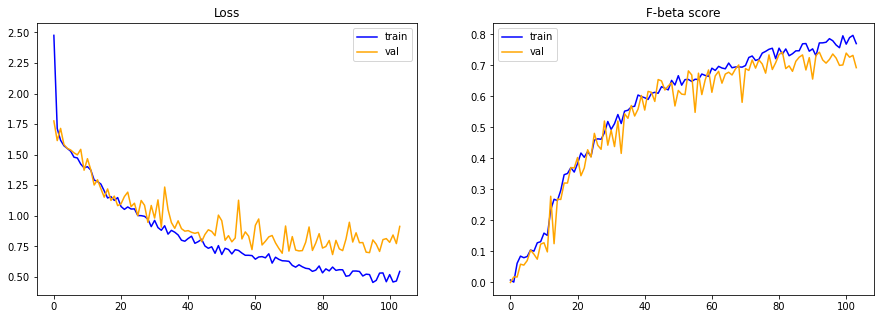

Model F-beta score :  0.7146170735359192


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model3_perf = evaluate_model(history)

Note : overfitting is reduced, performance is little lower

### model 4 : Baseline + data augmentation + dropout + batch normalization

Batch normalization helps
- stabilize learning
- accelerate learning (perhaps)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 16s 166ms/step - loss: 1.7297 - fbeta: 0.2538 - val_loss: 2.5309 - val_fbeta: 0.0324
Epoch 2/200
89/89 [==============================] - 14s 162ms/step - loss: 1.5059 - fbeta: 0.2843 - val_loss: 2.0428 - val_fbeta: 0.1882
Epoch 3/200
89/89 [==============================] - 14s 162ms/step - loss: 1.3044 - fbeta: 0.3500 - val_loss: 1.8819 - val_fbeta: 0.3221
Epoch 4/200
89/89 [==============================] - 15s 165ms/step - loss: 1.1322 - fbeta: 0.4512 - val_loss: 1.2781 - val_fbeta: 0.3824
Epoch 5/200
89/89 [==============================] - 15s 163ms/step - loss: 1.1125 - fbeta: 0.4557 - val_loss: 1.1439 - val_fbeta: 0.4794
Epoch 6/200
89/89 [==============================] - 15s 163ms/step - loss: 1.0220 - fbeta: 0.5048 - val_loss: 1.8675 - val_fbeta: 0.3853
Epoch 7/200
89/89 [=============================

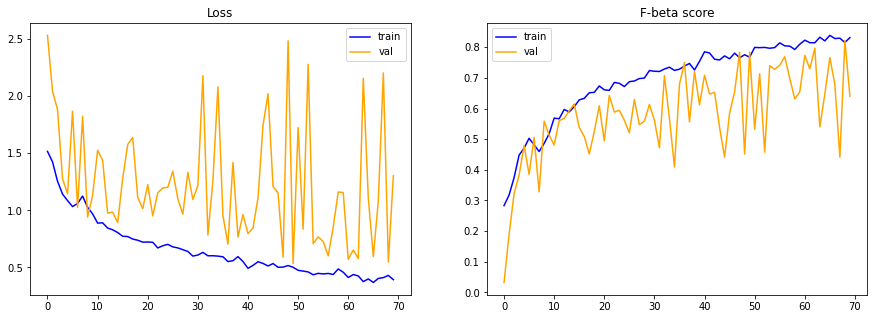

Model F-beta score :  0.6635730266571045


In [ ]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical')

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model4_perf = evaluate_model(history)

Note : The training result is smoother

## Improved model performance

In [ ]:
print('model 1 : ', model1_perf)
print('model 2 : ', model2_perf)
print('model 3 : ', model3_perf)
print('model 4 : ', model4_perf)

model 1 :  0.6171693205833435
model 2 :  0.7888630628585815
model 3 :  0.7146170735359192
model 4 :  0.6635730266571045


## Finalize the model
Train the selected model again.  
Give it more time to learn.  
Save the highest performance with ModelCheckpoint.

In [7]:
# create data generator with data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory(train_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory(val_dir,target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory(test_dir,target_size=(128, 128), batch_size=1, class_mode='categorical', shuffle=False)

# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint
mc = ModelCheckpoint(model_name, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es, mc],
                    epochs=300)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/300
89/89 [==============================] - 853s 10s/step - loss: 2.5695 - val_loss: 1.6318

Epoch 00001: val_loss improved from inf to 1.63184, saving model to best_vggblocks.h5
Epoch 2/300
89/89 [==============================] - 14s 160ms/step - loss: 1.6635 - val_loss: 1.6969

Epoch 00002: val_loss did not improve from 1.63184
Epoch 3/300
89/89 [==============================] - 14s 159ms/step - loss: 1.6612 - val_loss: 1.6442

Epoch 00003: val_loss did not improve from 1.63184
Epoch 4/300
89/89 [==============================] - 14s 160ms/step - loss: 1.5585 - val_loss: 1.4827

Epoch 00004: val_loss improved from 1.63184 to 1.48266, saving model to best_vggblocks.h5
Epoch 5/300
89/89 [==============================] - 14s 159ms/step - loss: 1.4941 - val_loss: 1.3839

Epoch 00005: val_loss improved from 1.48266 to 1.38390, saving model to best_vggbloc

In [10]:
# get y_true
y_true = test_iter.classes
# get one-hot encoded y_true 
from keras.utils import to_categorical
y_true = to_categorical(y_true)

# get y_pred
import numpy as np
prediction = model.predict(test_iter)
y_pred = np.rint(prediction)

# print model score
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
print('Confusion Matrix')
print(confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nClassification Report')
print('\n', classification_report(y_true.argmax(axis=1), y_pred.argmax(axis=1)))
print('\nmodel f2 score : ', fbeta_score(y_true, y_pred, 2, average='samples'))

Confusion Matrix
[[61  0  1  2  5  1]
 [ 5 59  8  4  6  0]
 [ 2  1 58  7  0  0]
 [ 4  5  6 86  4  3]
 [ 2 11  4  3 52  2]
 [ 3  4  3  2  1 16]]

Classification Report

               precision    recall  f1-score   support

           0       0.79      0.87      0.83        70
           1       0.74      0.72      0.73        82
           2       0.72      0.85      0.78        68
           3       0.83      0.80      0.81       108
           4       0.76      0.70      0.73        74
           5       0.73      0.55      0.63        29

    accuracy                           0.77       431
   macro avg       0.76      0.75      0.75       431
weighted avg       0.77      0.77      0.77       431


model f2 score :  0.7679814385150812


In [11]:
!ls -la

total 41868
drwxr-xr-x 1 root root     4096 Jan 25 03:30 .
drwxr-xr-x 1 root root     4096 Jan 25 03:13 ..
-rw-r--r-- 1 root root 42849552 Jan 25 03:45 best_vggblocks.h5
drwxr-xr-x 1 root root     4096 Jan 20 17:27 .config
drwx------ 4 root root     4096 Jan 25 03:13 drive
drwxr-xr-x 1 root root     4096 Jan 20 17:27 sample_data


In [ ]:
!ls

best_vggblocks.h5  drive  sample_data


In [12]:
# copy saved model file to the project directory
import shutil

shutil.copyfile(model_name, project_dir+model_name)

'/content/drive/MyDrive/MyProjects/garbage_img_classification/best_vggblocks.h5'